In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
import scanpy
# sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.settings.set_figure_params(dpi=400,format='eps', transparent=True)

In [19]:
TE = pd.read_csv('TE_MTX.csv',index_col = 0)
TE.index.name='TE'
TE=TE.fillna(0)

X = TE.T.values
obs_names = TE.columns
obs = pd.DataFrame(index=obs_names)
var_names = TE.index
var = pd.DataFrame(index=var_names)

adata_unique = anndata.AnnData(X, obs=obs, var=var)
adata_unique.var["TE"] = TE.index.tolist()

C:\Users\roxan\AppData\Local\Temp\ipykernel_32412\2584278.py:11: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_unique = anndata.AnnData(X, obs=obs, var=var)


In [20]:
adata_unique

AnnData object with n_obs × n_vars = 3570 × 6114
    var: 'TE'

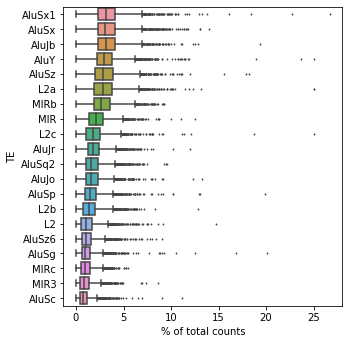

In [21]:
sc.pl.highest_expr_genes(adata_unique, n_top=20)

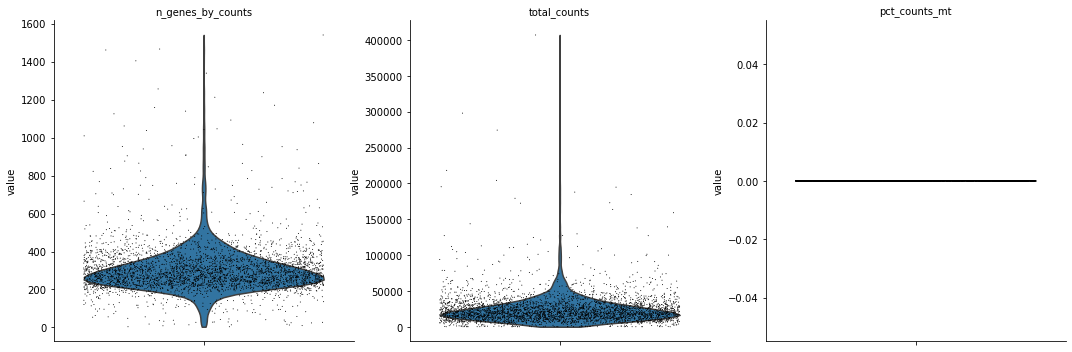

In [22]:
adata_unique.var['mt'] = adata_unique.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_unique, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata_unique, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

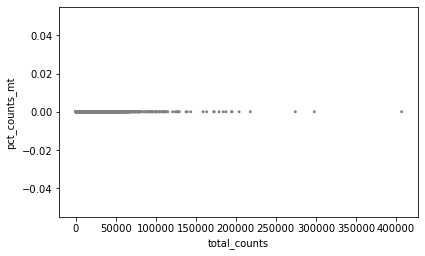

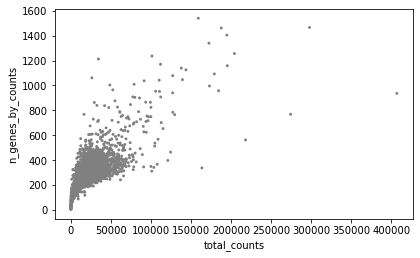

In [23]:
sc.pl.scatter(adata_unique, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_unique, x='total_counts', y='n_genes_by_counts')

In [24]:
# normalize counts in each cell to be equal
sc.pp.normalize_total(adata_unique, target_sum=10**4)
# Replace raw counts with their logarithm
sc.pp.log1p(adata_unique)

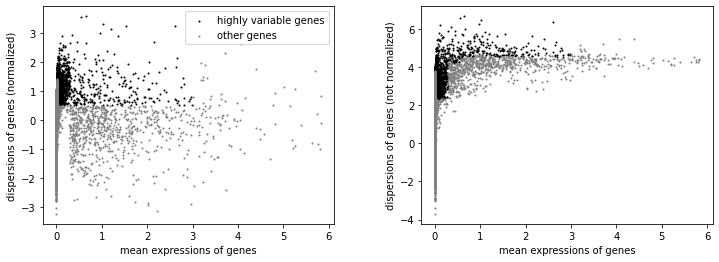

In [25]:
sc.pp.highly_variable_genes(adata_unique)
sc.pl.highly_variable_genes(adata_unique)

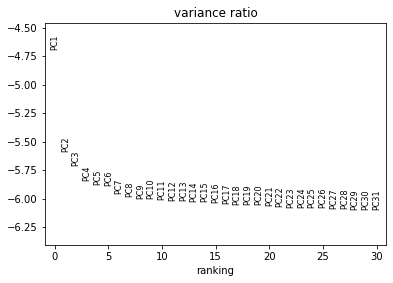

In [26]:
adata_unique.raw = adata_unique
adata_unique = adata_unique[:, adata_unique.var.highly_variable]
sc.pp.regress_out(adata_unique, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata_unique, max_value=10)
sc.tl.pca(adata_unique, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_unique, log=True)

In [27]:
adata_unique.obs['Run'] = adata_unique.obs.index
meta = pd.read_csv('SraRunTable.txt', sep = ',')
meta = meta[['Run', 'Cell_type']]
adata_unique.obs = adata_unique.obs.rename(columns={'cell': 'Run'})
adata_unique.obs = adata_unique.obs.merge(meta, how = 'left', on = ['Run'])

C:\Users\roxan\anaconda3\lib\site-packages\anndata\_core\anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [28]:
sc.pp.neighbors(adata_unique, n_neighbors=20, n_pcs=40)

In [29]:
import random
from sklearn.metrics import adjusted_rand_score
random.seed(21)
randomlist = random.sample(range(0, 50), 15)
ari = []
for i in randomlist:
    sc.tl.leiden(adata_unique, random_state = i)
    sc.tl.paga(adata_unique)
    sc.pl.paga(adata_unique, plot=False)
    sc.tl.umap(adata_unique, init_pos='paga')
    predict = adata_unique.obs.leiden.tolist()
    true = adata_unique.obs['Cell_type'].tolist()
    ari.append(adjusted_rand_score(predict, true))

In [31]:
np.mean(ari)

0.11552027199557709

In [30]:
adata_unique.var

,TE,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std
TE,,,,,,,,,,,,
(AAAAAAG)n,(AAAAAAG)n,False,6,0.027171,99.831933,97.0,True,0.018563,2.863808,0.854327,2.826538e-11,0.095779
(AAAAAC)n,(AAAAAC)n,False,56,0.156022,98.431373,557.0,True,0.063771,2.722419,0.766026,-3.547896e-11,0.184064
(AAAAACC)n,(AAAAACC)n,False,5,0.019328,99.859944,69.0,True,0.016971,3.962091,1.540233,-6.141603e-11,0.072542
(AAAAATA)n,(AAAAATA)n,False,22,0.063025,99.383754,225.0,True,0.029967,2.755255,0.786533,-1.695685e-11,0.122964
(AAAACC)n,(AAAACC)n,False,13,0.110644,99.635854,395.0,True,0.049238,3.367834,1.169104,-9.768534e-11,0.144761
...,...,...,...,...,...,...,...,...,...,...,...,...
tRNA-Thr-ACY_,tRNA-Thr-ACY_,False,26,0.054342,99.271709,194.0,True,0.017382,2.458317,0.601088,3.326152e-11,0.094110
tRNA-Trp-TGG,tRNA-Trp-TGG,False,13,0.061905,99.635854,221.0,True,0.038862,3.706251,1.380455,-4.173129e-11,0.120662
tRNA-Tyr-TAC,tRNA-Tyr-TAC,False,48,0.563025,98.655462,2010.0,True,0.180686,3.905123,1.504655,-2.024387e-10,0.266652


In [49]:
# te_list = pd.read_csv('top_TE.csv')

In [39]:
# te_list = te_list.TE.tolist()

In [40]:
# te_list.extend(['L1M3a','LTR2B', 'LTR5A', 'HERVK-int'])

In [42]:
adata_unique.var[adata_unique.var.TE.isin(te_list)]

,TE,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std
TE,,,,,,,,,,,,
(AAAAAAG)n,(AAAAAAG)n,False,6,0.027171,99.831933,97.0,True,0.018563,2.863808,0.854327,2.826538e-11,0.095779
(AAAAAC)n,(AAAAAC)n,False,56,0.156022,98.431373,557.0,True,0.063771,2.722419,0.766026,-3.547896e-11,0.184064
(AAAAACC)n,(AAAAACC)n,False,5,0.019328,99.859944,69.0,True,0.016971,3.962091,1.540233,-6.141603e-11,0.072542
(AAAAATA)n,(AAAAATA)n,False,22,0.063025,99.383754,225.0,True,0.029967,2.755255,0.786533,-1.695685e-11,0.122964
(AAAACC)n,(AAAACC)n,False,13,0.110644,99.635854,395.0,True,0.049238,3.367834,1.169104,-9.768534e-11,0.144761
...,...,...,...,...,...,...,...,...,...,...,...,...
tRNA-Thr-ACY_,tRNA-Thr-ACY_,False,26,0.054342,99.271709,194.0,True,0.017382,2.458317,0.601088,3.326152e-11,0.094110
tRNA-Trp-TGG,tRNA-Trp-TGG,False,13,0.061905,99.635854,221.0,True,0.038862,3.706251,1.380455,-4.173129e-11,0.120662
tRNA-Tyr-TAC,tRNA-Tyr-TAC,False,48,0.563025,98.655462,2010.0,True,0.180686,3.905123,1.504655,-2.024387e-10,0.266652


In [43]:
adata_unique.var[adata_unique.var.TE.isin(te_list)].to_csv('top_TE.csv')

In [32]:
sc.tl.rank_genes_groups(adata_unique, groupby='Cell_type', method='wilcoxon')

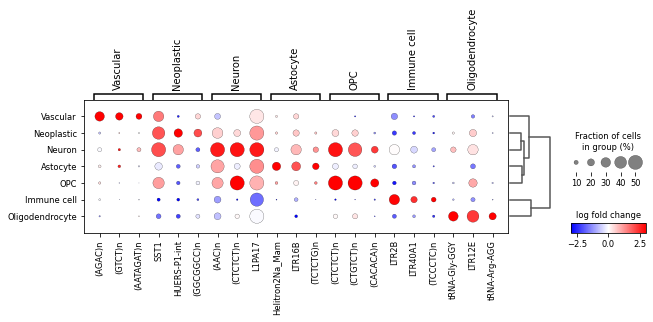

In [33]:
sc.pl.rank_genes_groups_dotplot(adata_unique, n_genes=3, min_logfoldchange=2, values_to_plot='logfoldchanges', dot_max = 0.5, vmax=3, vmin=-3, cmap='bwr', save = '')

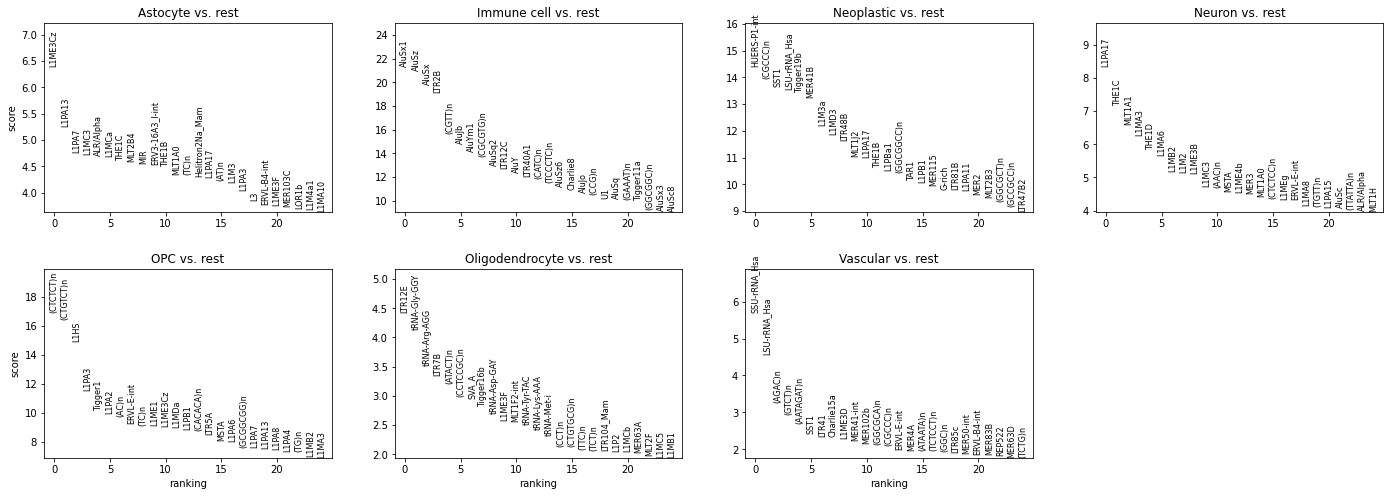

In [34]:
sc.tl.rank_genes_groups(adata_unique, 'Cell_type', method='t-test')
sc.pl.rank_genes_groups(adata_unique, n_genes=25, sharey=False)

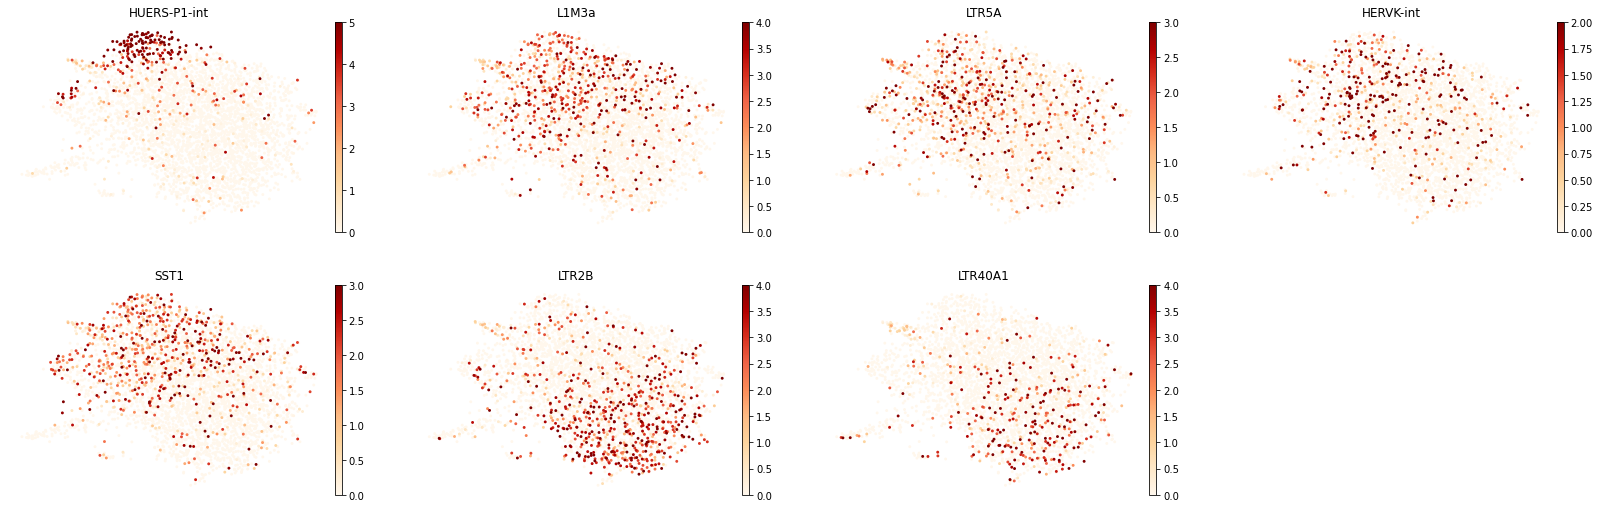

In [35]:
sc.pl.umap(adata_unique, color=['HUERS-P1-int','L1M3a', 'LTR5A', 'HERVK-int', 'SST1', 'LTR2B', 'LTR40A1'
        ],frameon = False, vmax = [5,4,3,2,3,4,4], color_map = 'OrRd')

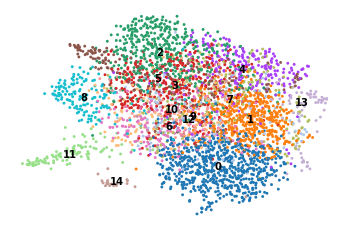

In [36]:
sc.pl.umap(adata_unique, color=['leiden'],title = '', legend_loc = 'on data', legend_fontsize = 10, frameon = False,
          )

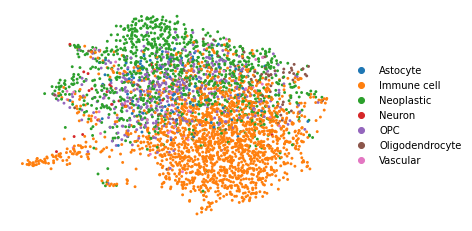

In [37]:
sc.pl.umap(adata_unique, color=['Cell_type'],title = '', colorbar_loc=None,frameon = False)